In [1]:
!pip install flax optax

In [2]:
import matplotlib.pyplot as plt
import optax
from tqdm.notebook import tqdm
from jax import numpy as jnp, random, value_and_grad, jit
from flax.linen import Module, Dense, sigmoid, compact
from jax.typing import ArrayLike
from typing import Dict, Callable, Tuple

plt.style.use("ggplot")

In [3]:
key = random.PRNGKey(18)
key_x, key_y, key_model = random.split(key, 3)
keys = {
    "x": key_x,
    "y": key_y,
    "model": key_model
}

In [4]:
keys

{'x': Array([2497588116, 2266319863], dtype=uint32),
 'y': Array([ 545267670, 2256313371], dtype=uint32),
 'model': Array([3826449569, 4181820671], dtype=uint32)}

In [5]:
RandomKeys = Dict[str, random.PRNGKey]
Data = Dict[str, ArrayLike]

In [6]:
!pip install black

In [7]:
%%writefile main.py
import numpy as np
x=np.array([1,2,3])
print(x)

Overwriting main.py


In [8]:
!black main.py

reformatted main.py

All done! ✨ 🍰 ✨
1 file reformatted.


In [9]:
!cat main.py

import numpy as np

x = np.array([1, 2, 3])
print(x)


In [10]:
def get_data(keys: RandomKeys, n_samples: int) -> Data:
    data = {
        "x": random.uniform(
            keys["x"], shape=(n_samples, 1), minval=-1, maxval=1
            )
    }
    data["y"] = (
        data["x"] ** 2 + 0.5 +
        random.normal(keys["y"], shape=(n_samples, 1)) * 0.2
    )
    data["y"] = data["y"] / data["y"].max()
    return data

In [11]:
data = get_data(keys, 1000)

[Text(0.5, 0, '$x$'), Text(0, 0.5, '$y$')]

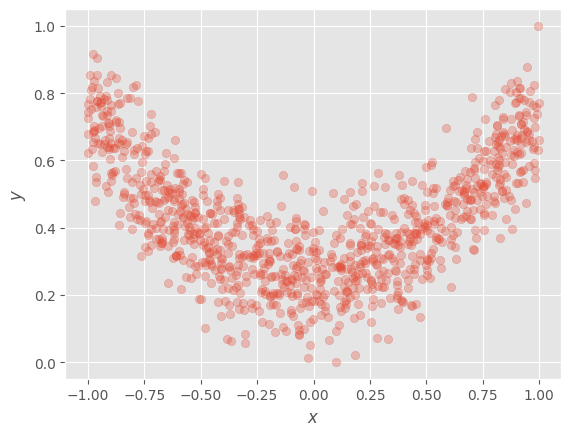

In [12]:
fig, ax = plt.subplots()
ax.scatter(data["x"], data["y"], alpha=0.3)
ax.set(xlabel="$x$", ylabel="$y$")

In [13]:
import time

In [14]:
def f(*args, **kwargs):
    print(args)
    print(kwargs)

In [15]:
f(0, 1, 2)

(0, 1, 2)
{}


In [16]:
f(param1="hola", verbose=True)

()
{'param1': 'hola', 'verbose': True}


In [17]:
def with_time(f: Callable) -> Callable:
    def new_f(*args, **kwargs):
        t0 = time.time()
        res = f(*args, **kwargs)
        t1 = time.time()
        return res, t1 -t0
    return new_f

In [18]:
@with_time
def suma(a: float, b: float) -> float:
    return a + b

In [19]:
suma(1, 2)

(3, 7.152557373046875e-07)

In [20]:
class Regressor(Module):

    @compact
    def __call__(self, x: ArrayLike) -> ArrayLike:
        h = sigmoid(Dense(features=32)(x))
        y_pred = sigmoid(Dense(features=1)(h))
        return y_pred

In [21]:
model = Regressor()

In [22]:
print(model.tabulate(keys["model"], data["x"]))


                               Regressor Summary                                
┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module    ┃ inputs           ┃ outputs          ┃ params           ┃
┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│         │ Regressor │ float32[1000,1]  │ float32[1000,1]  │                  │
├─────────┼───────────┼──────────────────┼──────────────────┼──────────────────┤
│ Dense_0 │ Dense     │ float32[1000,1]  │ float32[1000,32] │ bias:            │
│         │           │                  │                  │ float32[32]      │
│         │           │                  │                  │ kernel:          │
│         │           │                  │                  │ float32[1,32]    │
│         │           │                  │                  │                  │
│         │           │                  │                  │ 64 (256 B)       │
├─────────┼───────────┼────

In [23]:
params = model.init(keys["model"], data["x"])

In [24]:
params

{'params': {'Dense_0': {'kernel': Array([[ 0.7404448 , -0.4187589 ,  0.8600372 ,  1.1304576 , -0.13650064,
           -0.5417465 ,  0.7931985 , -1.4851663 , -0.4027159 ,  1.9600325 ,
            0.49493268, -0.61039317,  1.6104816 , -1.3284072 ,  2.2056024 ,
            1.1067272 , -1.3824681 ,  1.8880712 ,  0.38171884,  0.6582834 ,
            0.48846835,  0.43509194,  0.03397464,  0.16366349,  0.05828717,
            0.8275882 ,  0.19610713,  0.40220678, -1.545562  ,  0.3973577 ,
           -0.09168456,  1.4010642 ]], dtype=float32),
   'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32)},
  'Dense_1': {'kernel': Array([[-0.2791775 ],
          [ 0.2292504 ],
          [-0.18035372],
          [ 0.3519861 ],
          [ 0.21388668],
          [ 0.08490945],
          [-0.19630198],
          [-0.00658577],
          [-0.00972836],
          [ 0.24273598],
        

In [25]:
Params = Dict[str, Dict[str, Dict[str, ArrayLike]]]

In [26]:
def get_grad_loss(data: Data, model: Module) -> Callable[
    [Params], Tuple[ArrayLike, Params]
    ]:
    def loss_fn(params: Params) -> ArrayLike:
        y_pred = model.apply(params, data["x"])
        loss_val = ((data["y"] - y_pred) ** 2).mean()
        return loss_val
    return jit(value_and_grad(loss_fn))

In [27]:
grad_fn = get_grad_loss(data, model)
grad_fn(params)

(Array(0.04207966, dtype=float32),
 {'params': {'Dense_0': {'bias': Array([-3.41346138e-03,  2.77585257e-03, -2.21453118e-03,  4.36361972e-03,
            2.57757562e-03,  1.03152462e-03, -2.40460248e-03, -8.24710442e-05,
           -1.17749594e-04,  3.05283349e-03, -3.77313048e-03, -2.61786068e-03,
           -2.04389868e-03,  3.69287422e-03,  2.89138826e-03, -2.15375703e-03,
           -4.98067820e-04,  3.19183804e-03, -6.51769747e-04, -8.46999028e-05,
           -2.60403892e-03,  8.23802111e-05,  5.47945383e-04,  1.09313894e-03,
            5.76436461e-04, -2.08209414e-04,  5.28436736e-04,  4.72103711e-03,
           -3.77008296e-03,  6.08712668e-04, -1.67219457e-03, -1.03245140e-03],      dtype=float32),
    'kernel': Array([[-3.08066141e-04,  2.70879827e-04, -1.92313310e-04,
             3.41837411e-04,  2.60272471e-04,  9.81540361e-05,
            -2.13485953e-04, -5.49429342e-06, -1.15232124e-05,
             1.58704526e-04, -3.62748950e-04, -2.44990748e-04,
            -1.27886

In [28]:
optimizer = optax.adam(learning_rate=1e-3)
params = model.init(keys["model"], data["x"])
opt_state = optimizer.init(params)

In [29]:
opt_state

(ScaleByAdamState(count=Array(0, dtype=int32), mu={'params': {'Dense_0': {'bias': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32), 'kernel': Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],      dtype=float32)}, 'Dense_1': {'bias': Array([0.], dtype=float32), 'kernel': Array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], dtype=float32)}}}, nu={'params': {'Dense_0': {'bias': Array([0., 0.,

In [30]:
@jit
def train_step(params: Params, opt_state: Dict) -> Tuple[ArrayLike, Params, Dict]:
    value, grad = grad_fn(params)
    updates, opt_state = optimizer.update(params, opt_state)
    params = optax.apply_updates(params, updates)
    return value, params, opt_state

In [31]:
N_ITERS = 5000
pbar = tqdm(range(N_ITERS))
loss_log = []
for _ in pbar:
    loss_val, params, opt_state = train_step(params, opt_state)
    pbar.set_description(f"Loss: {loss_val}")
    loss_log.append(loss_val)

  0%|          | 0/5000 [00:00<?, ?it/s]

[Text(0.5, 0, 'Iter'), Text(0, 0.5, 'Loss')]

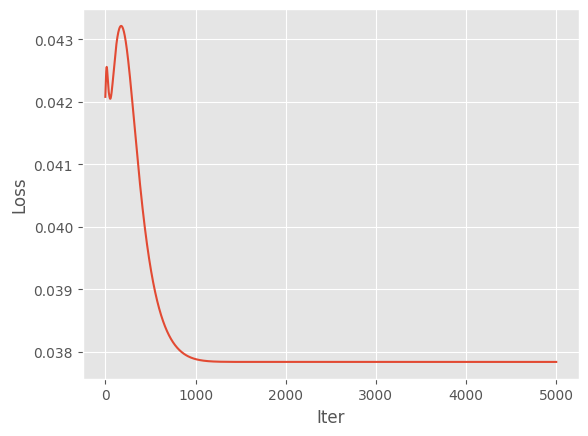

In [32]:
fig, ax = plt.subplots()
ax.plot(loss_log)
ax.set(xlabel="Iter", ylabel="Loss")

In [33]:
x_range = jnp.linspace(-1, 1, 100).reshape(-1, 1)
y_pred = model.apply(params, x_range)

[Text(0.5, 0, '$x$'), Text(0, 0.5, '$y$')]

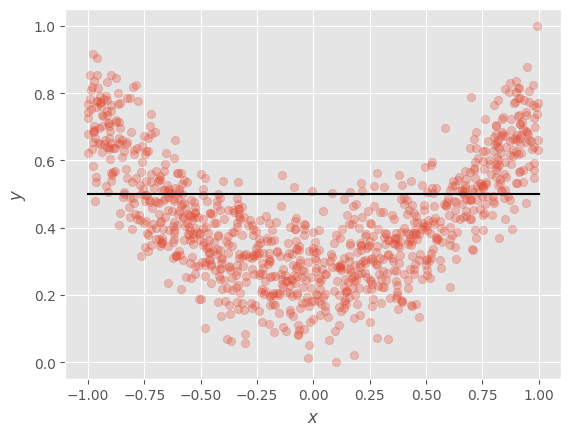

In [34]:
fig, ax = plt.subplots()
ax.scatter(data["x"], data["y"], alpha=0.3, label="Data")
ax.plot(x_range, y_pred, c="k", label="Prediction")
ax.set(xlabel="$x$", ylabel="$y$")